# ViT from scratch

## Overview

Main Components:
- Patch + Position Embedding
    - Linear projection: patch turned into a learnable embedding
- Layer Norm: regularizing per layer distribution (over activations per hidden unit in a layer)
- Transformer Encoder
    - Multi-head self attention (MSA)
    - MLP + GELU
- MLP Classifer Head


## Main Equations

\begin{align}
\mathbf{z}_0 &= [\mathbf{x}_{\text{class}}; \mathbf{x}_p^1 \mathbf{E}; \mathbf{x}_p^2 \mathbf{E}; \cdots; \mathbf{x}_p^N \mathbf{E}] + \mathbf{E}_{\text{pos}}, 
& \mathbf{E} \in \mathbb{R}^{(P^2 \cdot C) \times D},\ \mathbf{E}_{\text{pos}} \in \mathbb{R}^{(N+1)\times D} \tag{1} \\
\mathbf{z}'_\ell &= \text{MSA}(\text{LN}(\mathbf{z}_{\ell-1})) + \mathbf{z}_{\ell-1}, 
& \ell = 1 \ldots L \tag{2} \\
\mathbf{z}_\ell &= \text{MLP}(\text{LN}(\mathbf{z}'_\ell)) + \mathbf{z}'_\ell, 
& \ell = 1 \ldots L \tag{3} \\
\mathbf{y} &= \text{LN}(\mathbf{z}_L^0) \tag{4}
\end{align}


> Eq 1: Transformer keeps constant latent vector size D. Flatten patches to D dimensions with a trainable linear projection. Add class embedding and positional embedding (Patch Embeddings + Position Embeddings).  

* $\displaystyle \mathbf{z}_{0}$ is “z zero” (this is the output of the initial patch embedding layer).
- `E*x` = Embedding * image patch (linear projection to flatten patches)

> Eq 2 / 3: LN + MSA + LN + MLP + Residual Connection  

- $l$ is layer is for some Transformer encoder block layer
* $\displaystyle \mathbf{z}_{\ell}^{\prime}$ is “z of a particular layer prime” (an intermediary value of $\mathbf{z}$ after MSA).

* $\displaystyle \mathbf{z}_{\ell}$ is “z of a particular layer.” (output after MLP)

> Eq 4: Extract classification token (gets global attention from all patches)  

* And $\displaystyle \mathbf{y}$ is the output logits of the architecture.

![alt text](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png)

## Eq 1. Patch Embeddings

$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$

- E is for patch and position embeddings
- N is # of patches
- D is # of input dims to encoder (E is linear projection to D)
- P is patch dim. and C is # of channels

`x_input = [class_token, image_patch_1, ...] + [class_token_position. image_patch_1_position, ...]`

## Eq 2. MSA

$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

`x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input`
- layer norm and MSA input then add original input for residual connection
- $l$ is the encoder layer we are at (1 to $L$)

## Eq 3. MLP

$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\ \end{aligned} $$

- same as (2) but with a MLP

## Eq 4. Classification token

$$ \begin{aligned} \mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & & \end{aligned} $$


y = Linear_layer(LN_layer(x_output_MLP_block[0]))

ViT Base:
- layers: 12
- hidden size (D): 768 (Embedding dimension for QKV and linear projection)
- MLP size: 3072
- Heads: 12 (for Multi-head)
- total params: 86M

In [ ]:
# import common scripts and functions
import sys
import os
# print(sys.path)
sys.path.append('../lib')
sys.path.append('/pub/tyleryy/Models-from-Scratch/lib')
import data_setup, engine, helper_functions, utils

['/data/homezvol0/tyleryy/.conda/envs/Won_Lab/lib/python310.zip', '/data/homezvol0/tyleryy/.conda/envs/Won_Lab/lib/python3.10', '/data/homezvol0/tyleryy/.conda/envs/Won_Lab/lib/python3.10/lib-dynload', '', '/data/homezvol0/tyleryy/.conda/envs/Won_Lab/lib/python3.10/site-packages', '../lib', '../lib']


In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

In [84]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Hyperparams

In [64]:
# Hyperparameters

IMG_SIZE = 224
BATCH_SIZE = 32 # 4096 in the paper
HEIGHT, WIDTH = 224, 224 # (H, W)
IN_CHANNELS = 3 # (C)
PATCH_SIZE = 16 # (P)
NUM_OF_PATCHES = (HEIGHT * WIDTH) // PATCH_SIZE**2 # (N)
EMBEDDING_SIZE = PATCH_SIZE**2 * IN_CHANNELS # (D)
# 768 -> (N, P**2 * C) 
MLP_SIZE = 3072
HEADS = 12
NUM_OF_ENCODER_LAYERS = 12
MLP_DROPOUT = 0.1
EMBEDDING_DROPOUT = 0.1

# Training

LR=3e-3 # LR from Table 3 for ViT-* ImageNet-1k
BETAS=(0.9, 0.999) # default Adam values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
WEIGHT_DECAY=0.3 # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k


# num of patches -> 196 (N) -> (H * W) / P**2

assert HEIGHT % PATCH_SIZE == 0 and WIDTH % PATCH_SIZE == 0, "Patch size doesn't evenly divide image dims"

## Load sample image

In [7]:
# Download pizza, steak, sushi images from GitHub
image_path = helper_functions.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [8]:
train_dir = str(image_path) + "/train"
test_dir = str(image_path) + "/test"

train_dir, test_dir

('data/pizza_steak_sushi/train', 'data/pizza_steak_sushi/test')

In [9]:
# Transforms
manual_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [70]:
# Dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fd58c150dc0>,
 ['pizza', 'steak', 'sushi'])

In [11]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label.item()

(torch.Size([3, 224, 224]), 0)

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

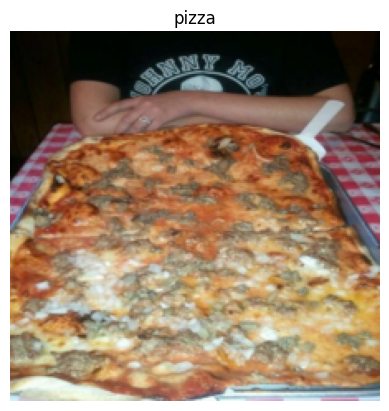

In [12]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

# Eq 1 - Patch Embedding

$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$


## Linear Projection

To practice each step, we will run a single sample image and perform tensor operations to simulate each step in each equation. Also, we want to make sure shape sizes match.

### Visual representation of patches

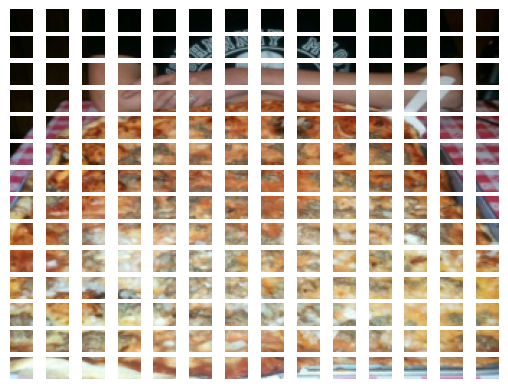

In [13]:
permuted_image = image.permute(1,2,0) # (H, W, C) for matplot

# Create a series of subplots
fig, axs = plt.subplots(nrows=IMG_SIZE // PATCH_SIZE,
                        ncols=IMG_SIZE // PATCH_SIZE)

for i, patch_height in enumerate(range(0, HEIGHT, PATCH_SIZE)):
    for j, patch_width in enumerate(range(0, WIDTH, PATCH_SIZE)):
        axs[i, j].imshow(permuted_image[patch_height:patch_height+PATCH_SIZE,
                                        patch_width:patch_width+PATCH_SIZE,
                                        :])
        axs[i, j].axis('off')
        # print(HEIGHT, PATCH_SIZE, i, j)


### Patchify Code (step by step)

In [14]:
image = image.unsqueeze(dim=0)
image.shape

torch.Size([1, 3, 224, 224])

In [15]:
# use Conv2D to linearly project to embedding space (D)
# equivalent of using a nn.Linear(IN_CHANNELS, EMBEDDING_SIZE)
# AKA linear projecting each patch (N) to embedding space and restructuring as N embeddings of dim D
linear_projection = nn.Conv2d(in_channels=3, 
                       out_channels=EMBEDDING_SIZE, 
                       kernel_size=PATCH_SIZE,
                       stride=PATCH_SIZE)
projected_image = linear_projection(image)
projected_image.shape

torch.Size([1, 768, 14, 14])

In [16]:
# flatten patches and reorder
embedding = nn.Flatten(start_dim=2, end_dim=3)(projected_image)
embedding = embedding.permute(0, 2, 1)
embedding.shape # (B, N, D), where B is batch size

torch.Size([1, 196, 768])

## Class Token + Positional Embedding

In [17]:
# add class token
class_token = torch.ones(1, 1, 768) # use randn, using ones for demo purposes
embedding_and_class_token = torch.concat((class_token, embedding), dim=1)
embedding_and_class_token.shape, embedding_and_class_token[:, :5, :5]

(torch.Size([1, 197, 768]),
 tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
          [-1.7770e-02, -2.1743e-02, -5.2994e-03,  1.4008e-02,  1.4305e-02],
          [-2.4052e-02, -1.9861e-02, -4.0078e-03,  1.3444e-02,  2.6055e-02],
          [-1.5893e-02, -1.2355e-02, -4.0811e-03,  3.0875e-03, -1.9137e-03],
          [-7.3676e-03, -9.7614e-03,  3.3789e-03,  5.2862e-03, -5.2799e-04]]],
        grad_fn=<SliceBackward0>))

In [18]:
# add positional embedding
positional_embedding = torch.ones(1, NUM_OF_PATCHES + 1, EMBEDDING_SIZE)
print(positional_embedding.shape)
patch_embedding = embedding_and_class_token + positional_embedding
patch_embedding.shape

torch.Size([1, 197, 768])


torch.Size([1, 197, 768])

### Putting it all together!

In [78]:
class PatchEmbedding(nn.Module):
    """Patch Embedding layer

    1. Linear projects to embedding space
    2. Appends Class Token
    3. Adds Positional Embedding
    
    """

    def __init__(self, HEIGHT, WIDTH, IN_CHANNELS, PATCH_SIZE):
        super().__init__()
        
        assert HEIGHT % PATCH_SIZE == 0 and WIDTH % PATCH_SIZE == 0, "Patch size doesn't evenly divide image dims"

        self.num_of_patches = (HEIGHT * WIDTH) // PATCH_SIZE**2 # N
        self.embedding_size = PATCH_SIZE**2 * IN_CHANNELS # D

        self.linear_projection = nn.Conv2d(in_channels=3, 
                                            out_channels=self.embedding_size, 
                                            kernel_size=PATCH_SIZE, # P
                                            stride=PATCH_SIZE) # P
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

        # torch.nn layers need to be in constructor as object vars to be tracked in summary
        self.class_token = nn.Parameter(torch.randn(1, 1, self.embedding_size),
                                   requires_grad=True)
        self.positional_embedding = nn.Parameter(torch.rand(1, self.num_of_patches + 1, self.embedding_size),
                                                       requires_grad=True)
        
    
    def forward(self, x): # (B, H, W, C)

        B = x.shape[0]
        # learnable tensors
        class_token = self.class_token.expand(B, -1, -1)
        
        # linear projection
        x = self.linear_projection(x) # B, D, P, P
        x = self.flatten(x) 
        x = x.permute(0, 2, 1) # B, N, D

        # concat class token
        x = torch.concat((class_token, x), dim=1) # B, N + 1, D

        # add positional embedding (addition is broadcasted across batch size)
        x = x + self.positional_embedding # B, N + 1, D

        return x # B, N + 1, D

PatchEmbedding(HEIGHT, WIDTH, IN_CHANNELS, PATCH_SIZE)(image).shape


torch.Size([1, 197, 768])

# Eq 2. MSA

$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

In [20]:
patch_embedding = PatchEmbedding(HEIGHT, WIDTH, IN_CHANNELS, PATCH_SIZE)(image)
patch_embedding.shape

torch.Size([1, 197, 768])

In [21]:
# LN
ln = nn.LayerNorm(normalized_shape=EMBEDDING_SIZE)
ln_patch_embedding = ln(patch_embedding)
patch_embedding.shape

torch.Size([1, 197, 768])

In [22]:
# MSA
msa = nn.MultiheadAttention(EMBEDDING_SIZE, HEADS, dropout=0)
msa_patch_embedding, _ = msa(ln_patch_embedding, ln_patch_embedding, ln_patch_embedding) # Q, K, V same for self attention
msa_patch_embedding.shape

torch.Size([1, 197, 768])

In [23]:
# Residual Connection
msa_output = msa_patch_embedding + patch_embedding
msa_output.shape

torch.Size([1, 197, 768])

In [24]:
class MSA_Block(nn.Module):

    def __init__(self, EMBEDDING_SIZE, NUM_OF_HEADS, DROPOUT):
        super().__init__()
        self.ln = nn.LayerNorm(normalized_shape=EMBEDDING_SIZE)
        self.msa = nn.MultiheadAttention(EMBEDDING_SIZE, NUM_OF_HEADS, DROPOUT, batch_first=True)

    def forward(self, x):
        x = self.ln(x)
        attn_output, _ = self.msa(x, x, x)
        return attn_output # omit residual for Encoder block
    
msa_output = MSA_Block(EMBEDDING_SIZE, HEADS, 0)(patch_embedding) + patch_embedding
msa_output.shape

torch.Size([1, 197, 768])

# Eq 3. MLP

$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\ \end{aligned} $$

In [25]:
class MLP_Block(nn.Module):

    def __init__(self, EMBEDDING_SIZE, MLP_SIZE, MLP_DROPOUT):
        super().__init__()
        self.ln = nn.LayerNorm(EMBEDDING_SIZE)
        self.mlp = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, MLP_SIZE),
            nn.GELU(),
            nn.Dropout(MLP_DROPOUT),
            nn.Linear(MLP_SIZE, EMBEDDING_SIZE),
            nn.Dropout(MLP_DROPOUT)
        )

    def forward(self, x):
        return self.mlp(self.ln(x))

mlp_output = MLP_Block(EMBEDDING_SIZE, MLP_SIZE, MLP_DROPOUT)(msa_output) + msa_output
mlp_output.shape

torch.Size([1, 197, 768])

## Transformer Encoder (combining Eq 2 and 3)

In [26]:
class Transformer_Encoder_Block(nn.Module):

    def __init__(self, EMBEDDING_SIZE, NUM_OF_HEADS, MLP_SIZE, MLP_DROPOUT, ATTN_DROPOUT=0):
        super().__init__()

        # eq 2
        self.msa_block = MSA_Block(EMBEDDING_SIZE, NUM_OF_HEADS, ATTN_DROPOUT)
        
        # eq 3
        self.mlp_block = MLP_Block(EMBEDDING_SIZE, MLP_SIZE, MLP_DROPOUT)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

block_output = Transformer_Encoder_Block(EMBEDDING_SIZE, HEADS, MLP_SIZE, MLP_DROPOUT, 0)(patch_embedding)
block_output.shape

torch.Size([1, 197, 768])

# Eq 4. Class token extraction

$$ \begin{aligned} \mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & & \end{aligned} $$


In [27]:
nn.LayerNorm(normalized_shape=EMBEDDING_SIZE)(block_output[:, 0, :]).shape # LN(class token)

torch.Size([1, 768])

# ViT all together!

\begin{align}
\mathbf{z}_0 &= [\mathbf{x}_{\text{class}}; \mathbf{x}_p^1 \mathbf{E}; \mathbf{x}_p^2 \mathbf{E}; \cdots; \mathbf{x}_p^N \mathbf{E}] + \mathbf{E}_{\text{pos}}, 
& \mathbf{E} \in \mathbb{R}^{(P^2 \cdot C) \times D},\ \mathbf{E}_{\text{pos}} \in \mathbb{R}^{(N+1)\times D} \tag{1} \\
\mathbf{z}'_\ell &= \text{MSA}(\text{LN}(\mathbf{z}_{\ell-1})) + \mathbf{z}_{\ell-1}, 
& \ell = 1 \ldots L \tag{2} \\
\mathbf{z}_\ell &= \text{MLP}(\text{LN}(\mathbf{z}'_\ell)) + \mathbf{z}'_\ell, 
& \ell = 1 \ldots L \tag{3} \\
\mathbf{y} &= \text{LN}(\mathbf{z}_L^0) \tag{4}
\end{align}


In [28]:
class MyViT(nn.Module):

    def __init__(self, HEIGHT, WIDTH, IN_CHANNELS, EMBEDDING_DROPOUT, PATCH_SIZE, NUM_OF_HEADS,
                 NUM_OF_ENCODER_LAYERS, MLP_SIZE, MLP_DROPOUT, NUM_OF_CLASSES, ATTN_DROPOUT = 0):
        super().__init__()
        self.NUM_OF_PATCHES = (HEIGHT * WIDTH) // PATCH_SIZE**2 # (N)
        self.EMBEDDING_SIZE = PATCH_SIZE**2 * IN_CHANNELS # (D)
        assert HEIGHT % PATCH_SIZE == 0 and WIDTH % PATCH_SIZE == 0, "Patch size doesn't evenly divide image dims"

        # Eq. 1
        self.patch_embedding = PatchEmbedding(HEIGHT, WIDTH, IN_CHANNELS, PATCH_SIZE)
        self.embedding_dropout = nn.Dropout(EMBEDDING_DROPOUT)

        # Eq. 2 and 3
        self.encoder = nn.Sequential(
            *[Transformer_Encoder_Block(EMBEDDING_SIZE, NUM_OF_HEADS, MLP_SIZE, MLP_DROPOUT, ATTN_DROPOUT) 
              for _ in range(NUM_OF_ENCODER_LAYERS)]
        )
        
        # classifier head (Eq. 4)
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=EMBEDDING_SIZE),
            nn.Linear(EMBEDDING_SIZE, NUM_OF_CLASSES)
        )

    def forward(self, x): # B, C, H, W
        
        x = self.patch_embedding(x) # B, N+1, D
        x = self.embedding_dropout(x)
        x = self.encoder(x) # B, N+1, D
        x = self.classifier(x[:, 0]) # B, 1, D
        return x

In [80]:
vit = MyViT(HEIGHT, WIDTH, IN_CHANNELS, EMBEDDING_DROPOUT, PATCH_SIZE, HEADS,
            NUM_OF_ENCODER_LAYERS, MLP_SIZE, MLP_DROPOUT, len(class_names))

In [81]:
# make sure total # of params matches
summary(vit, input_size=(32, 3, 224, 224), 
        device="cpu",
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MyViT (MyViT)                                 [32, 3, 224, 224]    [32, 3]              --                   True
├─PatchEmbedding (patch_embedding)            [32, 3, 224, 224]    [32, 197, 768]       152,064              True
│    └─Conv2d (linear_projection)             [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                      [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                 [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (encoder)                        [32, 197, 768]       [32, 197, 768]       --                   True
│    └─Transformer_Encoder_Block (0)          [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─MSA_Block (msa_block)             [32, 197, 768]       [32, 197, 768]      

# Training and Evaluation

In [85]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [86]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=LR,
                             betas=BETAS, 
                             weight_decay=WEIGHT_DECAY)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
helper_functions.set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/data/homezvol0/tyleryy/.conda/envs/Won_Lab/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 1 | train_loss: 3.5388 | train_acc: 0.3242 | test_loss: 2.9833 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.8077 | train_acc: 0.2930 | test_loss: 1.3778 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2463 | train_acc: 0.3008 | test_loss: 1.7033 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2240 | train_acc: 0.4102 | test_loss: 1.6414 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1530 | train_acc: 0.2812 | test_loss: 1.3284 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1622 | train_acc: 0.2891 | test_loss: 1.4150 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1474 | train_acc: 0.3984 | test_loss: 1.2450 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1075 | train_acc: 0.4180 | test_loss: 1.2259 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1598 | train_acc: 0.3047 | test_loss: 1.0622 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2191 | train_acc: 0.2422 | test_loss: 1.3077 | test_acc: 0.2604


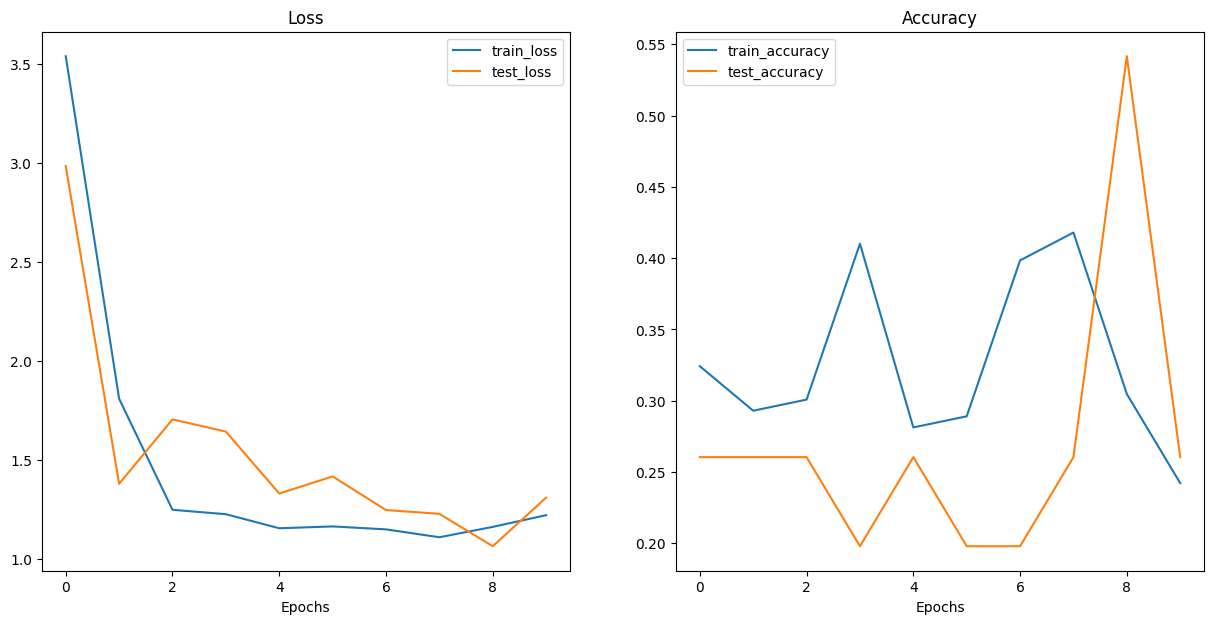

In [88]:
# Plot our ViT model's loss curves
helper_functions.plot_loss_curves(results)

Accuracy is pretty bad :(

This is because we are not finetuning from ViT's pretrained weights

# Pretrained ViT

In [90]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
helper_functions.set_seeds()

# these are unfrozen and trainable
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit 

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /data/homezvol0/tyleryy/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 330M/330M [00:01<00:00, 298MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [91]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [92]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


/data/homezvol0/tyleryy/.conda/envs/Won_Lab/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [93]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
helper_functions.set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/data/homezvol0/tyleryy/.conda/envs/Won_Lab/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5436 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1243 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2341 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2267 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2063 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


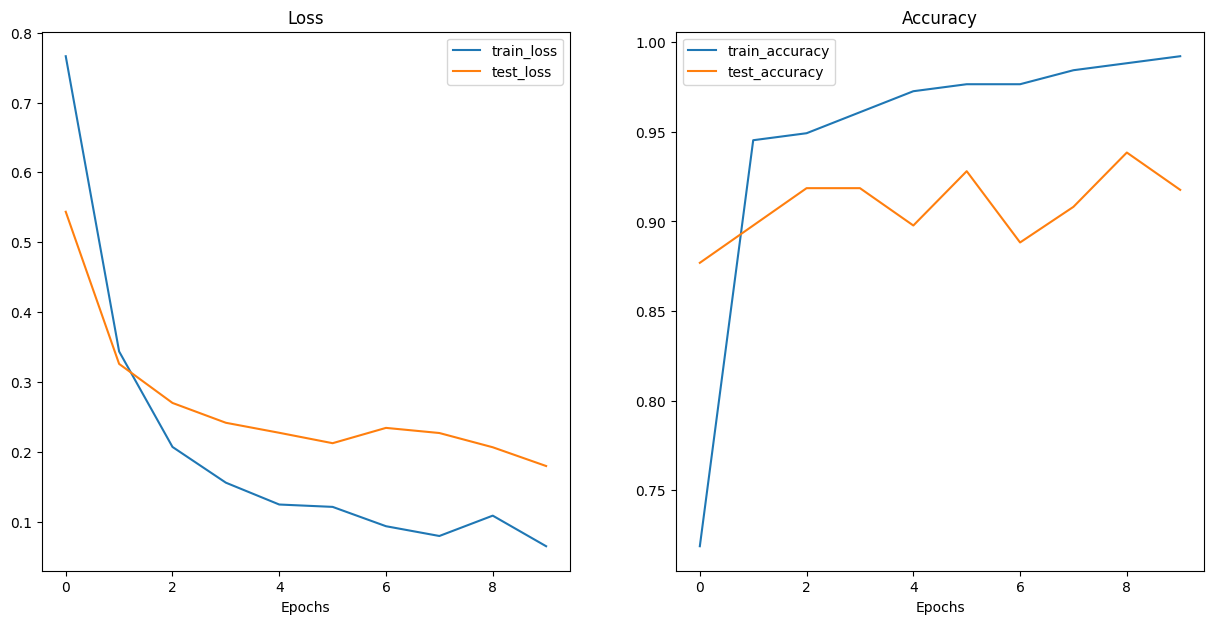

In [94]:
helper_functions.plot_loss_curves(pretrained_vit_results)

## Save model weights

In [95]:
utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [97]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB
